In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import models
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

In [3]:
TRAIN_DIR ="Training"
TEST_DIR  = "Testing"

labels = ["glioma", "meningioma", "notumor", "pituitary"]
image_size = 224
SEED = 42
N_TYPES=4

In [4]:
def load_data_to_ram(directory):
    X, y = [], []

    for label in labels:
        folderPath = os.path.join(directory, label)

        for img_name in tqdm(os.listdir(folderPath), desc=f"{label} yükleniyor"):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(labels.index(label))

    X = np.array(X, dtype="float32")
    y = np.array(y)

    X, y = shuffle(X, y, random_state=SEED)
    return X, y

In [5]:
X_full_train, y_full_train = load_data_to_ram(TRAIN_DIR)
X_test, y_test = load_data_to_ram(TEST_DIR)

X_train, X_val, y_train, y_val = train_test_split(
    X_full_train,
    y_full_train,
    test_size=0.2,
    stratify=y_full_train,
    random_state=SEED
)

y_train = tf.keras.utils.to_categorical(y_train, N_TYPES)
y_val   = tf.keras.utils.to_categorical(y_val, N_TYPES)
y_test  = tf.keras.utils.to_categorical(y_test, N_TYPES)

pituitary yükleniyor: 100%|█████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 469.04it/s]


## Hold Out

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    data_augmentation,
    Lambda(tf.keras.applications.efficientnet.preprocess_input),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [7]:
base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'cnn_model_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [23]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

input_tensor = Input(shape=(224, 224, 3))

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_tensor=input_tensor
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="efficientnetb0_model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=300
)

model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_6 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_3               │ (None, 224, 224, 3)       │               7 │ rescaling_6[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_7 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_7[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, 
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9259 - loss: 0.1899
Epoch 1: val_loss improved from inf to 0.24204, saving model to cnn_model_best.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 833ms/step - accuracy: 0.9259 - loss: 0.1899 - val_accuracy: 0.9108 - val_loss: 0.2420 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9277 - loss: 0.1978
Epoch 2: val_loss improved from 0.24204 to 0.22970, saving model to cnn_model_best.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 711ms/step - accuracy: 0.9277 - loss: 0.1978 - val_accuracy: 0.9143 - val_loss: 0.2297 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9298 - loss: 0.1768
Epoch 3: val_loss improved from 0.22970 to 0.22516, saving model to cnn_model_best.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 704ms/step - accuracy: 0.9298 - loss: 0.1768 - val_accuracy: 0.9143 - val_loss: 0.2252 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9334 - loss: 0.1896
Epoch 4: val_loss improved from 0.22516 to 0.21728, saving model to cnn_model_best.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.9334 - loss: 0.1896 - val_accuracy: 0.9151 - val_loss: 0.2173 - learning_rate: 1.0000e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9388 - loss: 0.1660
Epoch 5: val_loss did not improve from 0.21728
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 698ms/step - accuracy: 0.9388 - loss: 0.1661 - val_accuracy: 0.9090 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9331 - loss: 0.1884
Epoch 6: val_loss did not improve from 0.21728
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 696ms/step - accuracy: 0.9332 - loss: 0.1883 - val_accuracy: 0.9134 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9348 - loss: 0.1712
Epoch 7: val_loss improved from 0.21728 to 0.20582, saving model to cnn_model_best.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 722ms/step - accuracy: 0.9349 - loss: 0.1712 - val_accuracy: 0.9221 - val_loss: 0.2058 - learning_rate: 1.0000e-04
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9358 - loss: 0.1657
Epoch 8: val_loss did not improve from 0.20582
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 743ms/step - accuracy: 0.9358 - loss: 0.1657 - val_accuracy: 0.9186 - val_loss: 0.2145 - learning_rate: 1.0000e-04
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9327 - loss: 0.1793
Epoch 9: val_loss did not improve from 0.20582
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 709ms/step - accuracy: 0.9327 - loss: 0.1793 - val_accuracy: 0.9116 - val_loss: 0.2325 - learning_rate: 1.0000e-04
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9367 - loss: 0.1662
Epoch 10: val_loss did not improve from 0.20582
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 724ms/step - accuracy: 0.9367 - loss: 0.1662 - val_accuracy: 0.9160 - val_loss: 0.2140 - learning_rate: 1.0000e-

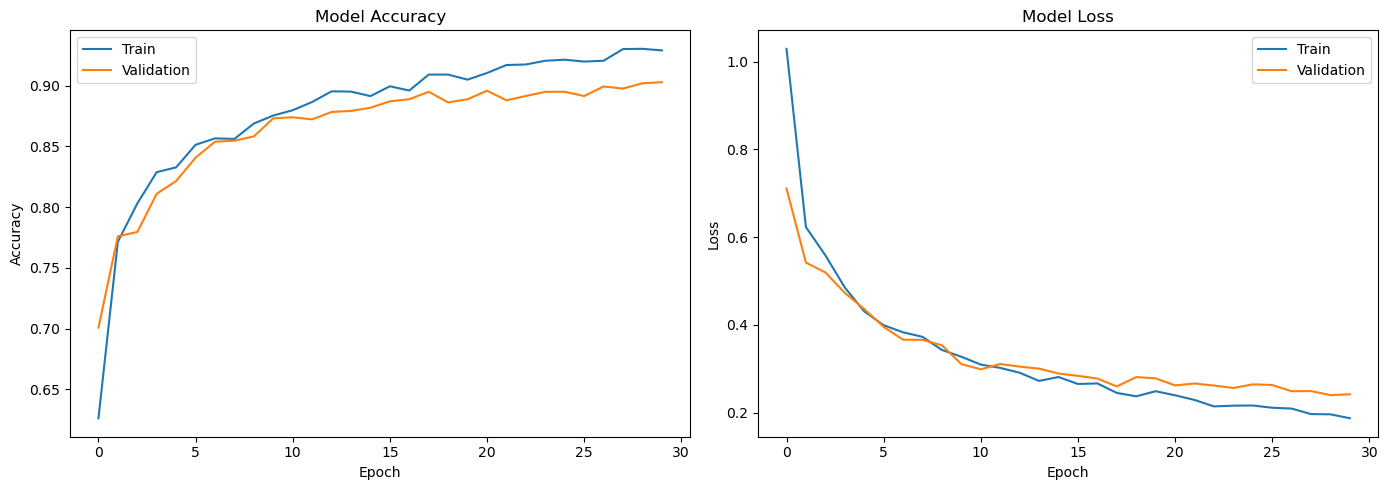

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))


axs[0].plot(history1.history['accuracy'], label='Train')
axs[0].plot(history1.history['val_accuracy'], label='Validation')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history1.history['loss'], label='Train')
axs[1].plot(history1.history['val_loss'], label='Validation')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

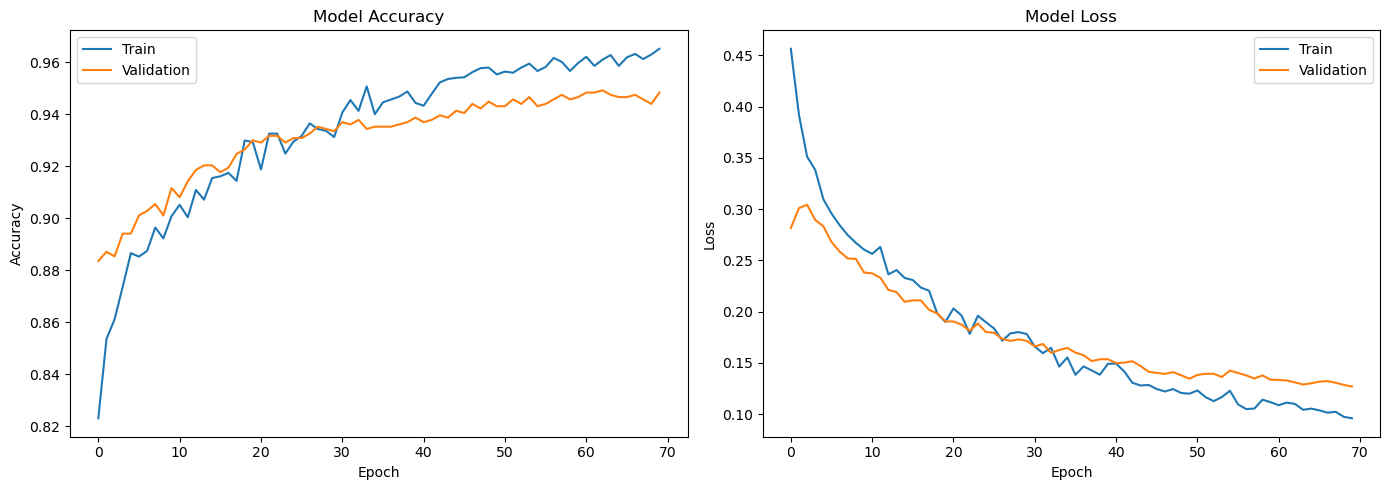

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(history2.history['accuracy'], label='Train')
axs[0].plot(history2.history['val_accuracy'], label='Validation')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history2.history['loss'], label='Train')
axs[1].plot(history2.history['val_loss'], label='Validation')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [12]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

In [19]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.9473684210526315


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

41/41 [==============================] - 18s 441ms/step - loss: 0.1321 - accuracy: 0.9504
Test Accuracy: 0.950419545173645


In [1]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("EfficientNetB0-Hold Out Confusion Matrix")
plt.show()

In [23]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

report = classification_report(
    y_true,
    y_pred,
    target_names=labels,
    output_dict=True
)


specificity = {}
for i, label in enumerate(labels):
    TN = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    FP = cm[:,i].sum() - cm[i,i]
    specificity[label] = TN / (TN + FP)

df = pd.DataFrame(report).transpose()
df = df.loc[labels, ['precision', 'recall', 'f1-score']]
df['specificity'] = [specificity[label] for label in labels]

print("EfficientNetB0 Hold Out - Performans Tablosu\n")
print(f"Accuracy: {acc:.3f}")
print("-" * 45)
print(df.round(4))

EfficientNetB0 Hold Out - Performans Tablosu

Accuracy: 0.947
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.9509  0.9033    0.9265       0.9862
meningioma     0.9085  0.8758    0.8918       0.9731
notumor        0.9902  0.9975    0.9938       0.9956
pituitary      0.9257  0.9967    0.9599       0.9763


41/41 [==============================] - 17s 423ms/step


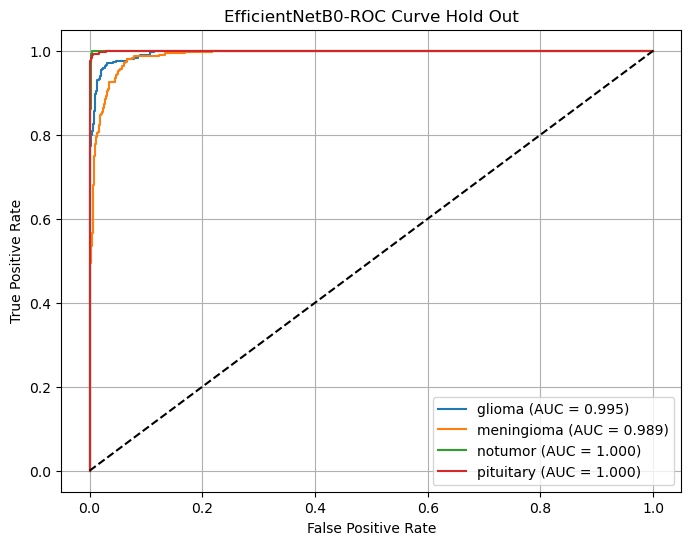

In [24]:
y_score = model.predict(X_test)
y_true = y_test

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(8, 6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")


plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetB0-ROC Curve Hold Out")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## K-Fold

In [8]:
K = 5
skf = StratifiedKFold(
    n_splits=K,
    shuffle=True,
    random_state=SEED
)

In [9]:
def build_model():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ])

    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = False

    model_kf = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224,224,3)),
        data_augmentation,
        tf.keras.layers.Lambda(
            tf.keras.applications.efficientnet.preprocess_input
        ),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation="softmax")
    ])

    model_kf.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model_kf

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_full_train, y_full_train)):
    print("\n====================")
    print(f"FOLD {fold+1}/{K}")
    print("====================")

    
    tf.keras.backend.clear_session()

  
    X_train_f = X_full_train[train_idx]
    X_val_f   = X_full_train[val_idx]

    y_train_f = y_full_train[train_idx]
    y_val_f   = y_full_train[val_idx]

  
    y_train_f = tf.keras.utils.to_categorical(y_train_f, N_TYPES)
    y_val_f   = tf.keras.utils.to_categorical(y_val_f, N_TYPES)


    model_kf = build_model()

   
    checkpoint_kf = ModelCheckpoint(
        f'best_model_fold_{fold+1}.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    early_stop_kf = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr_kf = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

  
    history_kf = model_kf.fit(
        X_train_f, y_train_f,
        validation_data=(X_val_f, y_val_f),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop_kf, reduce_lr_kf, checkpoint_kf],
        verbose=1
    )

    val_acc = max(history_kf.history['val_accuracy'])
    fold_accuracies.append(val_acc)

In [11]:
print("K-Fold Fold Accuracy Sonuçları:")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")

mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)

print("\n K-Fold Cross-Validation Sonuçları")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Std Accuracy : {std_acc:.4f}")

K-Fold Fold Accuracy Sonuçları:
Fold 1: 0.9081
Fold 2: 0.9178
Fold 3: 0.9054
Fold 4: 0.9221
Fold 5: 0.9081

📊 K-Fold Cross-Validation Sonuçları
Mean Accuracy: 0.9123
Std Accuracy : 0.0064


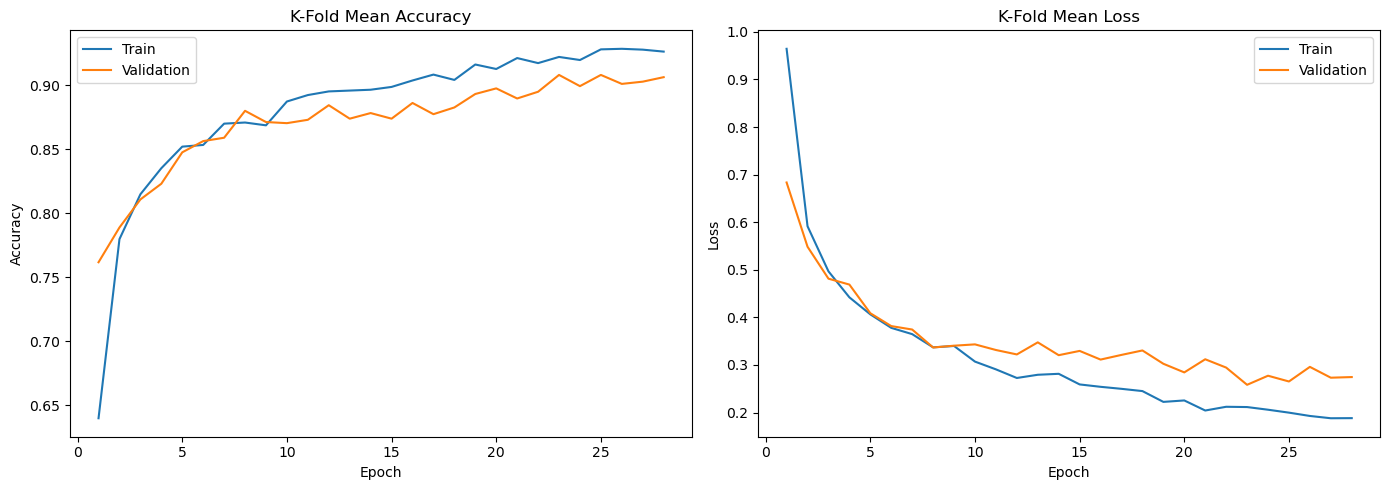

In [22]:
epochs = range(1, min_epochs + 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))


axs[0].plot(epochs, acc_avg, label='Train')
axs[0].plot(epochs, val_acc_avg, label='Validation')
axs[0].set_title('K-Fold Mean Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()


axs[1].plot(epochs, loss_avg, label='Train')
axs[1].plot(epochs, val_loss_avg, label='Validation')
axs[1].set_title('K-Fold Mean Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [35]:
y_val_prob = model_kf.predict(X_val_f, verbose=0)

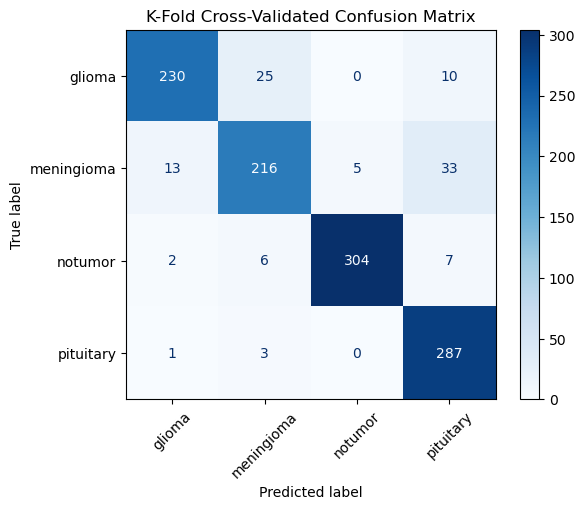

In [36]:
y_true_all = []
y_pred_all = []
y_prob_all = []

y_val_pred_prob = model_kf.predict(X_val_f, verbose=0)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)


y_val_true = np.argmax(y_val_f, axis=1)

y_true_all.extend(y_val_true)
y_pred_all.extend(y_val_pred)
y_prob_all.extend(y_val_prob)

cm = confusion_matrix(y_true_all, y_pred_all)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("K-Fold Cross-Validated Confusion Matrix")
plt.show()

In [20]:
acc_per_fold = []
val_acc_per_fold = []
loss_per_fold = []
val_loss_per_fold = []

acc_per_fold.append(history_kf.history['accuracy'])
val_acc_per_fold.append(history_kf.history['val_accuracy'])
loss_per_fold.append(history_kf.history['loss'])
val_loss_per_fold.append(history_kf.history['val_loss'])

min_epochs = min(len(acc) for acc in acc_per_fold)

acc_avg = np.mean([acc[:min_epochs] for acc in acc_per_fold], axis=0)
val_acc_avg = np.mean([acc[:min_epochs] for acc in val_acc_per_fold], axis=0)
loss_avg = np.mean([loss[:min_epochs] for loss in loss_per_fold], axis=0)
val_loss_avg = np.mean([loss[:min_epochs] for loss in val_loss_per_fold], axis=0)

In [28]:
report = classification_report(
    y_true_all,
    y_pred_all,
    target_names=labels,
    output_dict=True
)

specificity = {}

for i, label in enumerate(labels):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    specificity[label] = TN / (TN + FP)

performance_table = []

for label in labels:
    performance_table.append({
        "precision": report[label]["precision"],
        "recall": report[label]["recall"],
        "f1-score": report[label]["f1-score"],
        "specificity": specificity[label]
    })

df = pd.DataFrame(report).transpose()
df = df.loc[labels, ['precision', 'recall', 'f1-score']]
df['specificity'] = [specificity[label] for label in labels]

print("EfficientNetB0 K-Fold - Performans Tablosu\n")
print(f"Accuracy: {acc:.3f}")
print("-" * 45)
print(df.round(4))

EfficientNetB0 K-Fold - Performans Tablosu

Accuracy: 0.908
---------------------------------------------
            precision  recall  f1-score  specificity
glioma         0.9350  0.8679    0.9002       0.9818
meningioma     0.8640  0.8090    0.8356       0.9611
notumor        0.9838  0.9530    0.9682       0.9939
pituitary      0.8516  0.9863    0.9140       0.9412


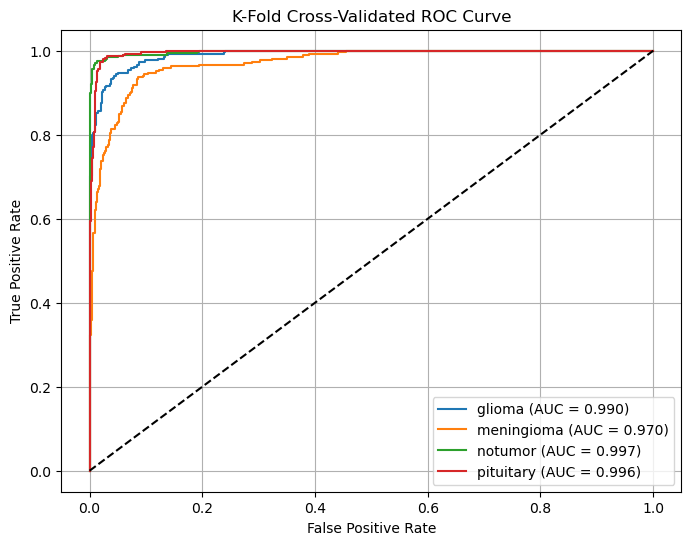

In [40]:
y_true_bin = label_binarize(y_true_all, classes=range(N_TYPES))
y_prob_all = np.array(y_prob_all)

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(8,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("K-Fold Cross-Validated ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()